# Import all necessary libraries

In [59]:
import numpy as np 
import matplotlib.pyplot as plt
import jax
import networkx as nx
import jax.numpy as jnp
from jax import random
from jax.lax import scan
from matplotlib.colors import TwoSlopeNorm
from torchvision import datasets, transforms

# Network Architecture

In [60]:
def generate_neural_network(num_neurons, excitatory_ratio=0.8, connection_prob=0.1):
    """
    Generates a neural network with excitatory and inhibitory neurons.

    Args:
        num_neurons (int): Total number of neurons.
        excitatory_ratio (float): Proportion of excitatory neurons (default: 0.8, for 4:1 ratio).
        connection_prob (float): Probability of connection between any two neurons.
    
    Returns:
        G (nx.DiGraph): Directed graph representing the network.
    """
    # Number of excitatory and inhibitory neurons
    num_excitatory = int(num_neurons * excitatory_ratio)

    # Create directed graph
    G = nx.DiGraph()

    # Add nodes with attributes (excitatory or inhibitory)
    for i in range(num_neurons):
        if i < num_excitatory:
            G.add_node(i, type=1)
        else:
            G.add_node(i, type=-1)

    # Add edges with weights, respecting Dale's principle
    for i in range(num_neurons):
        for j in range(num_neurons):
            if i != j and np.random.rand() < connection_prob:
                if G.nodes[i]["type"] == 1:
                    weight = 1  # Positive weight for excitatory
                else:
                    weight = -1  # Negative weight for inhibitory
                G.add_edge(i, j, weight=weight)
    
    # Ensure each excitatory or inhibitory neuron has at least one outgoing connection
    for i in range(num_neurons):
        if len(list(G.out_edges(i))) == 0:  # No outgoing connections
            # Find a random target neuron
            target = np.random.choice(num_neurons)
            while target == i:  # Ensure no self-loop
                target = np.random.choice(num_neurons)
            if G.nodes[i]["type"] == 1:
                weight = 1  # Positive weight for excitatory
            else:
                weight = -1  # Negative weight for inhibitory
            G.add_edge(i, target, weight=weight)
    
    return G

def add_input_layer(G, num_input_nodes, subset_size, input_prob=0.5):
    """
    Adds an input layer to the neural network.

    Args:
        G (nx.DiGraph): Existing neural network graph.
        num_input_nodes (int): Number of input nodes to add.
        subset_size (int): Size of the subset of existing neurons to connect to.
        input_prob (float): Probability of connection from input nodes to subset neurons.

    Returns:
        G (nx.DiGraph): Updated graph with input layer.
    """
    num_existing_neurons = len(G.nodes)
    input_layer_start = num_existing_neurons

    # Add input nodes
    for i in range(num_input_nodes):
        G.add_node(input_layer_start + i, type=0)

    # Randomly select a subset of existing neurons
    subset_neurons = np.random.choice(num_existing_neurons, subset_size, replace=False)

    # Add edges from input nodes to subset neurons with the given probability
    for input_node in range(input_layer_start, input_layer_start + num_input_nodes):
        for target_neuron in subset_neurons:
            if np.random.rand() < input_prob:
                weight = 1  # Adjust weight range if needed
                G.add_edge(input_node, target_neuron, weight=weight)
    
    return G

def add_teacher_neuron(G, input_size, output_subset_size):
    
    last_neuron = len(G.nodes)
    G.add_node(last_neuron, type=2)
    
    out_subset_neurons = np.random.choice(last_neuron-input_size, output_subset_size, replace=False)
    
    for out in out_subset_neurons:
        G.add_edge(last_neuron, out, weight= -5) 
        
    return G, out_subset_neurons


def plot_network(G):
    """
    Plots the network, color-coding excitatory and inhibitory neurons.

    Args:
        G (nx.DiGraph): Directed graph representing the network.
    """
    pos = nx.random_layout(G)  # Layout for visualization
    excitatory_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == 1]
    inhibitory_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == -1]
    input_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == 0]
    output_nodes = [n for n, attr in G.nodes(data=True) if attr["type"] == 2]
    
    num_input_nodes = len(input_nodes)
    for i, node in enumerate(input_nodes):
        pos[node] = (-0.1, i / (num_input_nodes - 1) if num_input_nodes > 1 else 0.5)
    
    pos[output_nodes[0]] = (1.1, 0.5)

    plt.figure(figsize=(15,10))
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, nodelist=excitatory_nodes, node_color="red", label="Excitatory", alpha=0.7, node_size=50)
    nx.draw_networkx_nodes(G, pos, nodelist=inhibitory_nodes, node_color="blue", label="Inhibitory", alpha=0.7, node_size=50)
    nx.draw_networkx_nodes(G, pos, nodelist=input_nodes, node_color="green", label="Input Nodes", alpha=0.7, node_size=50)
    nx.draw_networkx_nodes(G, pos, nodelist=output_nodes, node_color="yellow", label="Teacher Node", alpha=0.7, node_size=50)

    # Draw edges
    excitatory_edges = [(u, v) for u, v, d in G.edges(data=True) if G.nodes[u]["type"] == 1]
    inhibitory_edges = [(u, v) for u, v, d in G.edges(data=True) if G.nodes[u]["type"] == -1]
    input_edges = [(u, v) for u, v, d in G.edges(data=True) if G.nodes[u]["type"] == 0]
    output_edges = [(u, v) for u, v, d in G.edges(data=True) if G.nodes[u]["type"] == 2]

    nx.draw_networkx_edges(G, pos, edgelist=excitatory_edges, edge_color="red", arrowstyle="->", arrowsize=10, alpha=0.7, label="Excitatory Connections")
    nx.draw_networkx_edges(G, pos, edgelist=inhibitory_edges, edge_color="blue", arrowstyle="->", arrowsize=10, alpha=0.7, label="Inhibitory Connections")
    nx.draw_networkx_edges(G, pos, edgelist=input_edges, edge_color="green", arrowstyle="->", arrowsize=10, alpha=0.7, label="Input Connections")
    nx.draw_networkx_edges(G, pos, edgelist=output_edges, edge_color="orange", arrowstyle="->", arrowsize=10, alpha=0.7, label="Teacher Connections")

    # Add legend
    plt.legend()
    plt.title("Neural Network with Excitatory and Inhibitory Neurons")
    plt.axis("off")
    plt.show()

# Neuron functions

## Hodgkin-Huxley Neuron

In [61]:
def alpha_n(V):
    return (0.01 * (10 - V)) /  (jnp.exp((10 - V) / 10) - 1)

def beta_n(V):
    return 0.125 * jnp.exp(- V/80)

def alpha_m(V):
    return (0.1 * (25 - V)) / (jnp.exp((25 - V) / 10) - 1)
    
def beta_m(V):
    return 4 * jnp.exp(- V/18)
    
def alpha_h(V):
    return 0.07 * jnp.exp(- V/20)
    
def beta_h(V):
    return 1 / (jnp.exp((30-V)/10) + 1)

In [62]:
def hh_dynamics(state, neuron_params, inputs):
    """AdEx neuron dynamics with spiking and refractory period."""
    
    g_k, g_Na, g_l = 35, 120, 0.3  # mS/cm²
    E_k, E_Na, E_l = -12, 115, 10.6  # mV
    I_ext, I_syn = inputs
    V, n, m, h = state

    dVdt = -g_k * n**4 * (V - E_k) - g_Na * m**3 * h * (V - E_Na) - g_l * (V - E_l) + I_ext + I_syn
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    
    
    
    V = V + dVdt * dt
    n = n + dndt * dt
    m = m + dmdt * dt
    h = h + dhdt *dt

    spiked = jnp.where(V > neuron_params["v_th"], 1, 0)
    
   # V = jnp.clip(V, -100.0, 150.0)
    
    
    return jnp.array([V, n, m, h]), spiked

# Synapse functions

## Simple exponential synapse

In [63]:
def synaptic_dynamics(syn_state, syn_params, pre_spike):
    """Exponential synaptic dynamics."""
    return syn_state + dt * (-syn_state / syn_params["tau_syn"] + pre_spike)

## Fancy synapse

# STDP

In [64]:
def update_weights(weights, pre_spikes, post_spikes, stdp_params):
    """Update synaptic weights using the STDP rule with exponential time dependence."""
    
    # Compute the time differences (t = t_post - t_pre) for each pair of neurons
    delta_t = post_spikes[:, None] - pre_spikes[None, :]
    
    # Calculate the weight updates for LTP (pre before post) and LTD (post before pre)
    delta_w_plus = stdp_params["A_plus"] * jnp.exp(-delta_t / stdp_params["tau_plus"]) * (delta_t > 0)  # t > 0: LTP
    delta_w_minus = stdp_params["A_minus"] * jnp.exp(delta_t / stdp_params["tau_minus"]) * (delta_t < 0)  # t < 0: LTD
    
    # Calculate the total weight change
    weight_updates = delta_w_plus - delta_w_minus

    # add here that weights cannot change direction - Dale's principle
    weight_updates = jnp.where(weights * (weights + weight_updates) < 0, 0, weight_updates)

    # Ensure that weights initialized to zero stay at zero (for the synapses with no connectivity)
    weights = jnp.where(connectivity == 0, weights, weights + weight_updates)
    
    weights = weights.at[:,N_main:].set(connectivity[:,N_main:])
    
    # Clip the weights to keep them within a defined range, avoiding runaway values
    return jnp.clip(weights, -1.5, 1.5)

# Simulation

In [65]:
# Network update function
def network_update_train(carry, t, params, I_ext):
    neuron_states, synapse_states, weights, key = carry
    key, subkey = random.split(key)


    pre_spikes = (neuron_states[:, 0] > params["neuron"]["v_th"]).astype(float)

    # Synaptic dynamics: update synapse states
    synapse_states = jax.vmap(synaptic_dynamics, in_axes=(0, None, 0))(
        synapse_states, params["synapse"], pre_spikes
    )
    I_syn = jnp.dot(weights, synapse_states)

    # Neuron dynamics: update states
    neuron_states, spiked = jax.vmap(hh_dynamics, in_axes=(0, None, 0))(
        neuron_states, params["neuron"], jnp.stack([I_ext, I_syn], axis=-1)
    )

    # Update weights with STDP
    weights = update_weights(weights, pre_spikes, spiked, params["stdp"])
    

    return (neuron_states, synapse_states, weights, key), None

In [66]:
# Network update function
def network_update_test(carry, t, params, I_ext):
    neuron_states, synapse_states, weights, key = carry
    key, subkey = random.split(key)


    pre_spikes = (neuron_states[:, 0] > params["neuron"]["v_th"]).astype(float)

    # Synaptic dynamics: update synapse states
    synapse_states = jax.vmap(synaptic_dynamics, in_axes=(0, None, 0))(
        synapse_states, params["synapse"], pre_spikes
    )
    I_syn = jnp.dot(weights, synapse_states)

    # Neuron dynamics: update states
    neuron_states, spiked = jax.vmap(hh_dynamics, in_axes=(0, None, 0))(
        neuron_states, params["neuron"], jnp.stack([I_ext, I_syn], axis=-1)
    )
    

    return (neuron_states, synapse_states, weights, key), (neuron_states[:, 0], spiked)

In [67]:
def simulate_train(T, dt, N, N_input, key, params, connectivity, image):
    neuron_states = jnp.stack([
        jnp.full((N,), 0),  # V
        jnp.full((N,), 0.317),  # n (steady state at rest potential)
        jnp.full((N,), 0.052),  # m (steady state at rest potential)
        jnp.full((N,), 0.596)   # h (steady state at rest potential)
    ], axis=-1)
    synapse_states = jnp.zeros(N)
    weights = jnp.array(connectivity) 
    carry = (neuron_states, synapse_states, weights, key)
    time_steps = jnp.arange(0, T, dt)
    
    input_index = N-N_input-1
    
    I_ext = jnp.zeros(len(neuron_states))
    I_ext = I_ext.at[input_index:N-1].set(image)
    
    I_ext = I_ext.at[N-1].set(64.0)

    carry, _ = scan(lambda carry, t: network_update_train(carry, t, params, I_ext), carry, time_steps)

    return jnp.array(carry[2]) 

In [68]:
def simulate_test(T, dt, N, N_input, key, params, connectivity, image):
    neuron_states = jnp.stack([
        jnp.full((N,), 0),  # V
        jnp.full((N,), 0.317),  # n (steady state at rest potential)
        jnp.full((N,), 0.052),  # m (steady state at rest potential)
        jnp.full((N,), 0.596)   # h (steady state at rest potential)
    ], axis=-1)
    synapse_states = jnp.zeros(N)
    weights = jnp.array(connectivity) 
    carry = (neuron_states, synapse_states, weights, key)
    time_steps = jnp.arange(0, T, dt)
    
    input_index = N-N_input
    
    I_ext = jnp.zeros(len(neuron_states))
    I_ext = I_ext.at[input_index:].set(image)
    
    carry, outputs = scan(lambda carry, t: network_update_test(carry, t, params, I_ext), carry, time_steps)
    membrane_potentials, spikes = outputs
    return jnp.array(membrane_potentials).T, jnp.array(spikes).T, jnp.array(carry[2]), time_steps

# Plot Results

In [69]:
def plot_results(time, membrane_potentials, spikes, weights):

    norm = TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 1, 1)
    plt.plot(time, membrane_potentials.T[:, :])
    plt.title("Membrane Potentials")
    plt.xlabel("Time (ms)")
    plt.ylabel("Potential (mV)")

    plt.subplot(2, 1, 2)
    plt.imshow(spikes, aspect="auto", cmap="gray_r", origin="lower")
    plt.title("Spike Raster Plot")
    plt.xlabel("Time Step")
    plt.ylabel("Neuron Index")
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(9,7))
    plt.imshow(connectivity[:,:], aspect="auto", cmap="seismic", origin="lower", norm=norm)
    plt.title("Synaptic Weights Beginning")
    plt.xlabel("Neuron Index")
    plt.ylabel("Neuron Index")
    plt.colorbar(label="Weight")
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(9,7))
    plt.imshow(weights[:,:], aspect="auto", cmap="seismic", origin="lower", norm=norm)
    plt.title("Synaptic Weights End")
    plt.xlabel("Neuron Index")
    plt.ylabel("Neuron Index")
    plt.colorbar(label="Weight")
    plt.tight_layout()
    plt.show()

In [70]:
def plot_test(time, V, output_neurons, label):

    plt.figure(figsize=(10, 6))
    plt.plot(time, V.T[:, output_neurons[0]], label="0")
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(time, V.T[:, output_neurons[1]], label="1")
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(time, V.T[:, output_neurons[2]], label="2")
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(time, V.T[:, output_neurons[3]], label="3")
    plt.show()
    plt.figure(figsize=(10, 6))
    plt.plot(time, V.T[:, output_neurons[4]], label="4")
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(time, V.T[:, output_neurons[5]], label="5")
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(time, V.T[:, output_neurons[6]], label="6")
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(time, V.T[:, output_neurons[7]], label="7")
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(time, V.T[:, output_neurons[8]], label="8")
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(time, V.T[:, output_neurons[9]], label="9")

    
    plt.title(f"Membrane Potentials - True Label: {label}")
    plt.xlabel("Time (ms)")
    plt.ylabel("Potential (mV)")
    plt.legend()
    plt.show()

# Parameters

In [71]:
params = {
    "neuron": {
        "v_rest": -65.0,  # Resting membrane potential (mV)
        "v_th": 40.0,    # Threshold potential (mV)
        "delta_T": 2.0,   # Slope factor (mV)
        "tau_v": 20.0,    # Membrane time constant (ms)
        "a": 0.5 ,        # Subthreshold adaptation (nS)
        "b": 7,         # Spike-triggered adaptation (nA)
        "tau_w": 100.0,   # Adaptation time constant (ms)
        "v_reset": -70.0, # Reset potential after spike (mV)
        "refractory": 2.0 # Refractory period (ms)
    },
    "synapse": {
        "tau_syn": 10.0  # Synaptic time constant (ms)
    },
    "stdp": {
        "A_plus": 0.02,   # STDP LTP increment
        "A_minus": 0.025, # STDP LTD decrement
        "tau_plus": 0.25, #0.01, # STDP LTP time constant (ms)
        "tau_minus": 0.25 #0.015 # STDP LTD time constant (ms)
    }
}

In [72]:
key = random.PRNGKey(42)
T = 50  # Simulation time (ms)
dt = 0.01  # Time step (ms)

# MNIST images

In [73]:
# Define transformations (convert to tensor, normalize)
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST(root="./data", train=True, download=False, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=False, transform=transform)

# Convert data to NumPy arrays
train_images = np.array([np.array(img[0]).squeeze() for img in train_dataset])
train_labels = np.array([label for _, label in train_dataset])

test_images = np.array([np.array(img[0]).squeeze() for img in test_dataset])
test_labels = np.array([label for _, label in test_dataset])

# Convert to JAX arrays
train_images = jnp.array(train_images, dtype=jnp.float32)
train_labels = jnp.array(train_labels, dtype=jnp.int32)

test_images = jnp.array(test_images, dtype=jnp.float32)
test_labels = jnp.array(test_labels, dtype=jnp.int32)

train_images = train_images * 255.0 / 4
test_images = test_images *255.0 / 4

# Train network

In [74]:
N = 1785
N_main = 1000
excitatory_ratio = 0.8
connection_prob = 0.1
N_input = 784
subset_size = 400
input_prob = 0.5

In [75]:
G = generate_neural_network(N_main, excitatory_ratio, connection_prob)
G = add_input_layer(G, N_input, subset_size, input_prob)
G, output_neurons = add_teacher_neuron(G, N_input, 10)

adj_matrix_sparse = nx.adjacency_matrix(G)
adj_matrix_dense = adj_matrix_sparse.toarray()
weights = jnp.array(adj_matrix_dense).T * 1.0

C:\Users\hanna\AppData\Local\Temp\ipykernel_6396\1449775576.py:5: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix_sparse = nx.adjacency_matrix(G)


In [76]:
for n in range(30):
    print("Training image:", n)
    
    image = train_images[n].flatten()
    label = train_labels[n]
    
    weights = weights.at[tuple(output_neurons), -1].set(-1.0)
    
    exc = output_neurons[label]
    weights = weights.at[exc, -1].set(1.0)
    connectivity = weights

    weights = simulate_train(T, dt, N, N_input, key, params, weights, image)
    
    jnp.save("trained_weights_test2.npy", weights, allow_pickle=True)

Training image: 0
Training image: 1
Training image: 2
Training image: 3
Training image: 4
Training image: 5
Training image: 6
Training image: 7
Training image: 8
Training image: 9
Training image: 10
Training image: 11
Training image: 12
Training image: 13
Training image: 14
Training image: 15
Training image: 16
Training image: 17
Training image: 18
Training image: 19
Training image: 20
Training image: 21
Training image: 22
Training image: 23
Training image: 24
Training image: 25
Training image: 26
Training image: 27
Training image: 28
Training image: 29


# Test network

In [78]:
N = 1784
T=200

weights = jnp.load("trained_weights_test2.npy")
weights = weights[:N, :N]

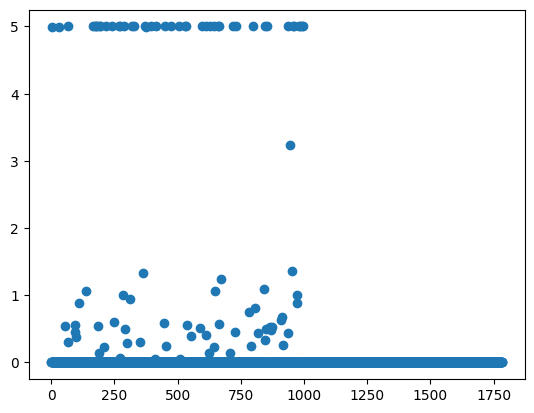

In [ ]:
plt.figure()
#plt.imshow(weights[:,:], aspect="auto", cmap="seismic", origin="lower")
plt.scatter(np.arange(0,1784,1), weights[:,400])

In [32]:
adj_matrix_sparse = nx.adjacency_matrix(G)
adj_matrix_dense = adj_matrix_sparse.toarray()
weights_old = jnp.array(adj_matrix_dense).T * 1.0

C:\Users\hanna\AppData\Local\Temp\ipykernel_6396\1144309215.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix_sparse = nx.adjacency_matrix(G)


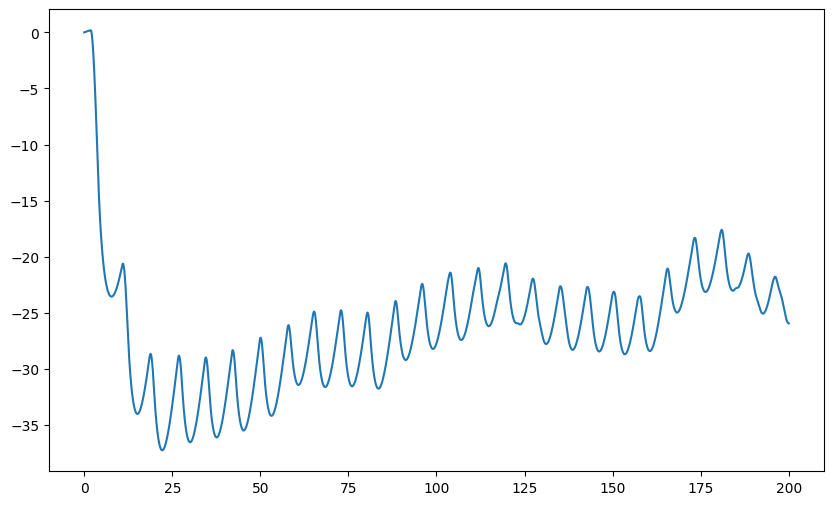

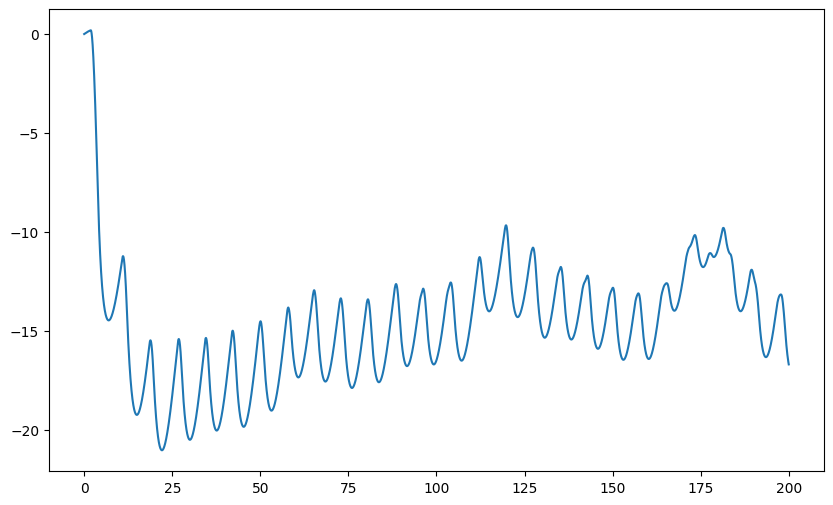

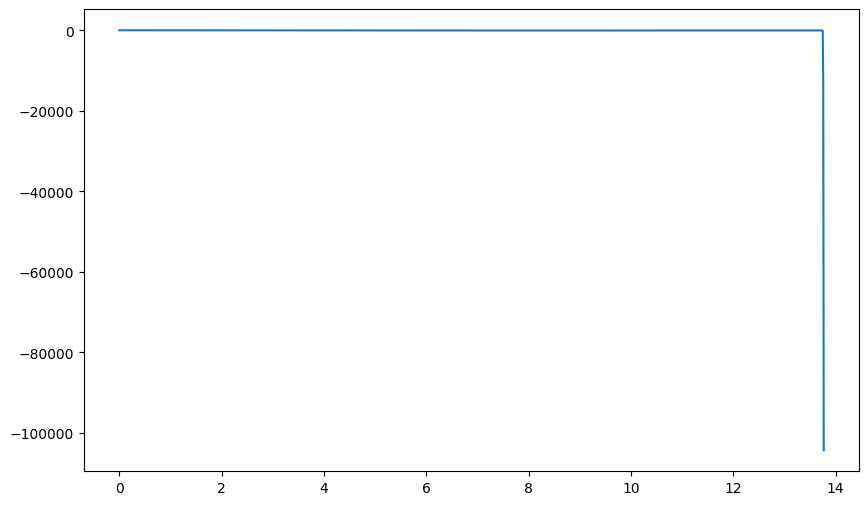

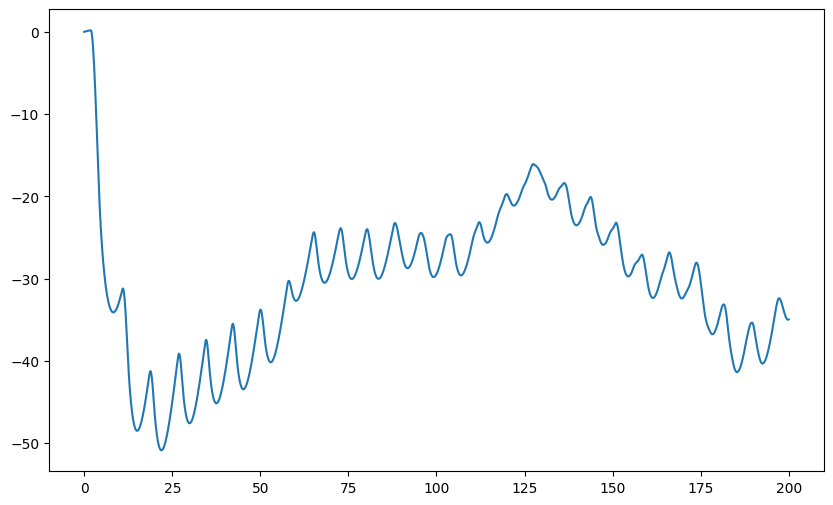

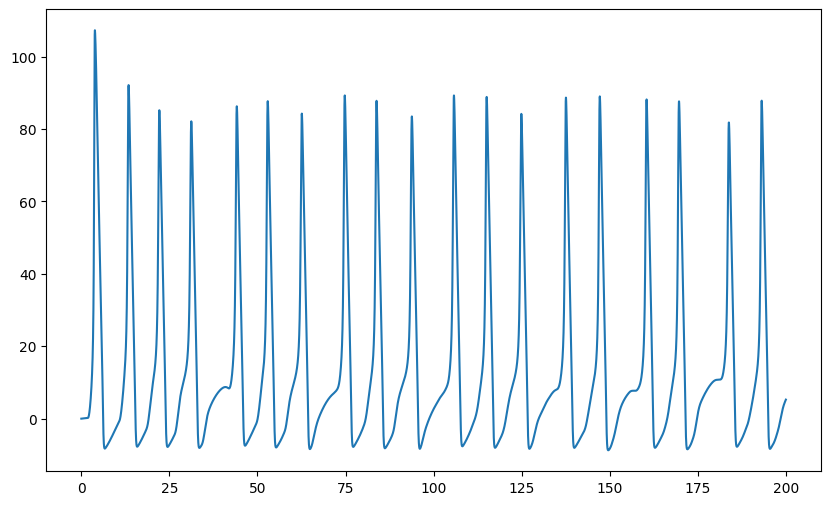

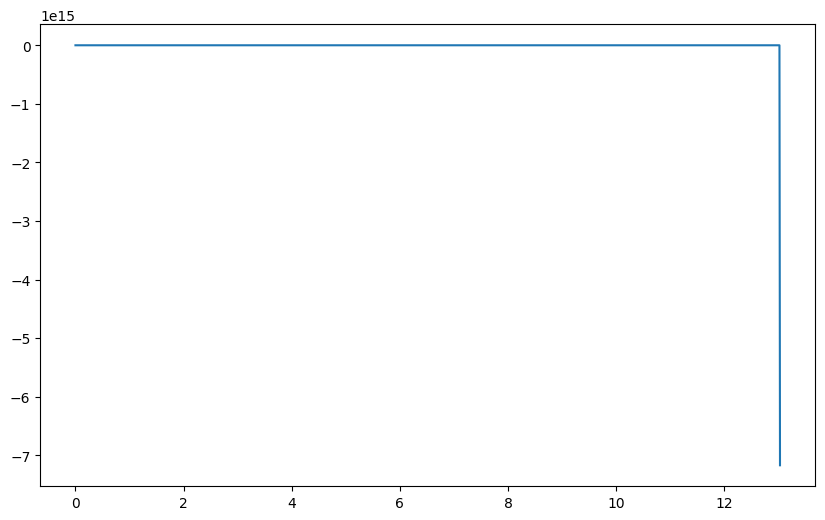

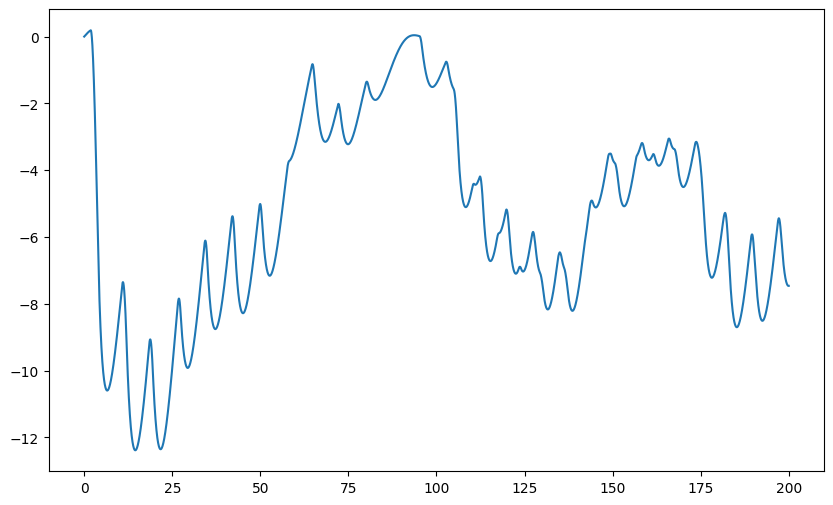

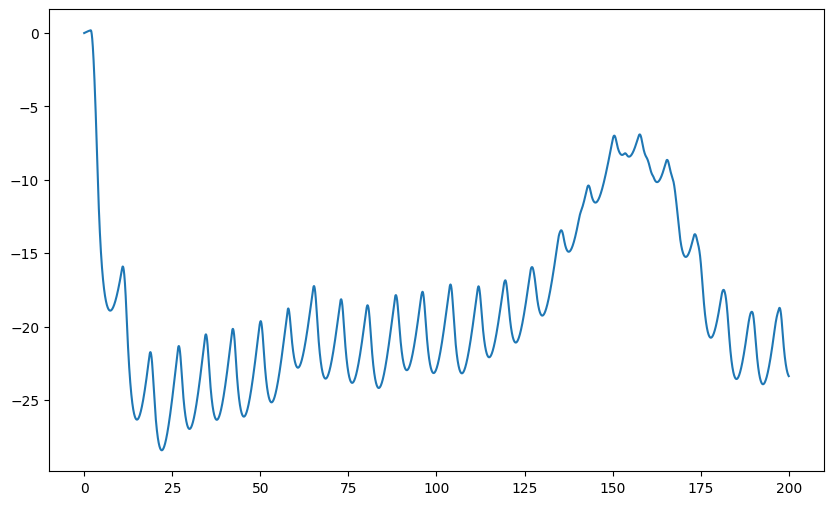

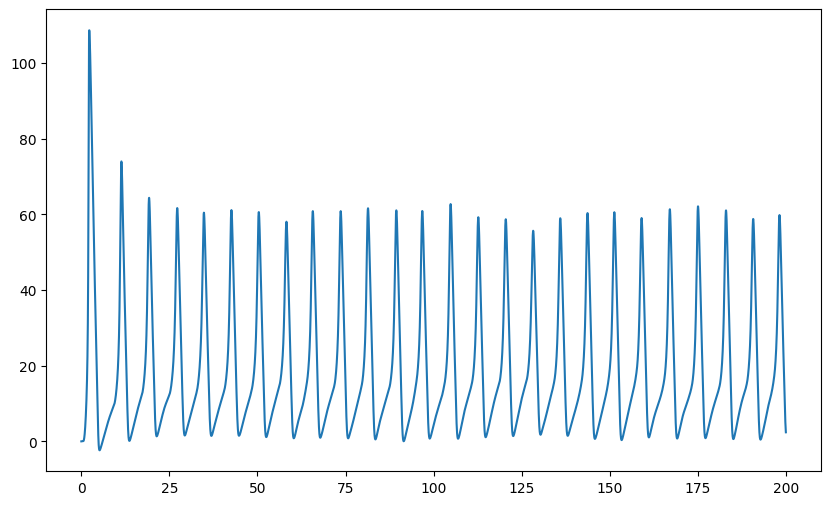

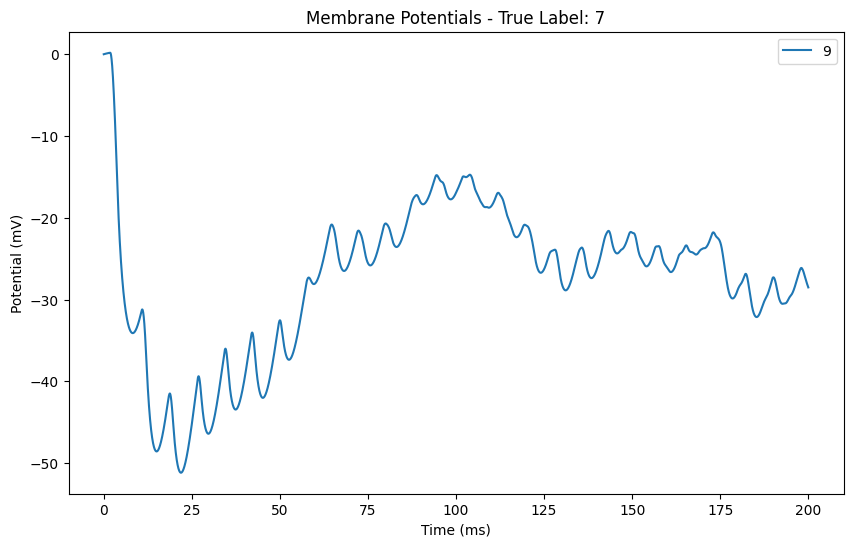

In [79]:
for n in range(1):
    image = test_images[n].flatten()
    label = test_labels[n]

    V, spikes, weights, time = simulate_test(T, dt, N, N_input, key, params, weights, image)

    plot_test(time, V, output_neurons, label)